In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
# display = pd.read_sql_query("""
# SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
# FROM Reviews
# GROUP BY UserId
# HAVING COUNT(*)>1
# """, con)

In [0]:
# print(display.shape)
# display.head()

In [0]:
# display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
# display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND UserId="AR5J8UI46CURR"
# ORDER BY ProductID
# """, con)
# display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
# display= pd.read_sql_query("""
# SELECT *
# FROM Reviews
# WHERE Score != 3 AND Id=44737 OR Id=64422
# ORDER BY ProductID
# """, con)

# display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# # printing some random reviews
# sent_0 = final['Text'].values[0]
# print(sent_0)
# print("="*50)

# sent_1000 = final['Text'].values[1000]
# print(sent_1000)
# print("="*50)

# sent_1500 = final['Text'].values[1500]
# print(sent_1500)
# print("="*50)

# sent_4900 = final['Text'].values[4900]
# print(sent_4900)
# print("="*50)

In [0]:
# # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
# sent_0 = re.sub(r"http\S+", "", sent_0)
# sent_1000 = re.sub(r"http\S+", "", sent_1000)
# sent_150 = re.sub(r"http\S+", "", sent_1500)
# sent_4900 = re.sub(r"http\S+", "", sent_4900)

# print(sent_0)

In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# sent_1500 = decontracted(sent_1500)
# print(sent_1500)
# print("="*50)

In [0]:
# #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
# sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
# print(sent_0)

In [0]:
# #remove spacial character: https://stackoverflow.com/a/5843547/4084039
# sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
# print(sent_1500)

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:00<00:00, 2016.51it/s]


In [0]:
preprocessed_reviews[1500]

'first impression friendly folks exclusively dog heard website sent products test let start saying love sweet treats taste dad considering trying one look smell much like human cookies plus ingredients straight forward probably healthier stuff mom eats lies problem dad thinks sweet puppy age second ingredient almost sugar know puppies hard time processing sugar like humans develop diabetes conclusion puppy nearly guaranteed love taste however used occasional treat feed puppies sugary sweet morsels every day would soon plump puppy already overweight not exercise regularly may want think twice pro side natural no animal bi products paws dad made judging taste alone would'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [14]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 364171/364171 [02:09<00:00, 2820.69it/s]


In [0]:
final["Cleaned_Text"] = preprocessed_reviews
final["Cleaned_Summary"] = preprocessed_summary

# Combining them

final["Final_Text"] = final['Cleaned_Text'].values + " " + final['Cleaned_Summary'].values 

In [16]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary,Final_Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...,good swingy rhythm reading aloud,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...,great way learn months,book poetry months year goes month cute little...


In [0]:
#Shape of our dataset

print(final.shape)

(364171, 13)


In [0]:
# #Store final table into an SQlLite table for future.
# connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
# c=connection_sqlobject.cursor()
# connection_sqlobject.text_factory = str
# final.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

# print("File is saved as 'totally_processed_DB.sqlite'")

In [0]:
X_train = final['Final_Text'].iloc[150000:250000,] ; y_train = final['Score'].iloc[150000:250000,]
X_test = final['Final_Text'].iloc[250000:280000,] ; y_test = final['Score'].iloc[250000:280000,]
X_calib = final['Final_Text'].iloc[280000:320000,] ; y_calib = final['Score'].iloc[280000:320000,]


# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer(min_df=10, max_features=20000, dtype='float')
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

X_train_vectors = count_vect.fit_transform(X_train)
X_test_vectors = count_vect.transform(X_test)
X_calib_vectors = count_vect.transform(X_calib)


In [19]:
print("The shape of our train BOW vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BOW vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

The shape of our train BOW vectorizer  (100000, 12552)
The shape of our test BOW vectorizer  (30000, 12552)
The number of unique words  12552


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (37415, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [0]:
tfidf_vect = TfidfVectorizer(min_df=10, max_features=20000).fit(X_train)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
X_calib_tfidf = tfidf_vect.transform(X_calib) 

## [4.4] Word2Vec

In [0]:
# #Build a Word2Vec model on train data and use this to vectorize the test and cv data.
# word2vec_corpus=[]
# for sentence in X_train:
#     word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
# print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

# word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=6) #min_count = 5 considers only those words for our model which occurs atleast 5 times
# word2vec_words = list(word2vec_model.wv.vocab)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

# #This method returns the Average Word2Vec vectors for all reviews in a given dataset
# def vectorize_w2v(dataset, word2vec_model, word2vec_words):
#     word2vec_corpus=[]
#     for sentence in dataset:
#         word2vec_corpus.append(sentence.split()) 
    
#     # Creating average Word2Vec model by computing the average word2vec for each review.
#     sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
#     for sentence in tqdm(word2vec_corpus): #For each review
#         sent_vec = np.zeros(50) #50 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
#         count_words =0; #This will store the count of the words with a valid vector in each review text
#         for word in sentence: #For each word in a given review.
#             if word in word2vec_words:
#                 word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
#                 sent_vec += word_vectors
#                 count_words += 1
#         if count_words != 0:
#             sent_vec /= count_words
#         sent_vectors.append(sent_vec)
#     #print("\nThe length of the sentence vectors :",len(sent_vectors))
#     #print("\nSize of each vector : ",len(sent_vectors[0]))
#     sent_vectors = np.array(sent_vectors)
#     return sent_vectors


# X_train_w2vec = vectorize_w2v(X_train, word2vec_model, word2vec_words)
# X_test_w2vec = vectorize_w2v(X_test, word2vec_model, word2vec_words)
# X_calib_w2vec = vectorize_w2v(X_calib, word2vec_model, word2vec_words)


In [0]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [0]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [0]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [37]:
# # Please write all the code with proper documentation

# # List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   

# List of sentence in X_cv
sent_of_cv=[]
for sent in X_calib:
    sent_of_cv.append(sent.split())   

# # Train your own Word2Vec model using your own train text corpus 
# # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


train_vectors = []
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_cv    
cv_vectors = []
for sent in sent_of_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_vectors.append(sent_vec)

number of words that occured minimum 5 times  18779


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(50) #50 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_tfidfw2vec = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_tfidfw2vec = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_tfidfw2vec = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

100%|██████████| 40000/40000 [25:32<00:00, 26.10it/s]

The shape of our TF-IDF Avg Word2Vec train vectorizer  (100000, 12552)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (30000, 12552)
The shape of our TF-IDF Avg Word2Vec calibration vectorizer  (40000, 12552)


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

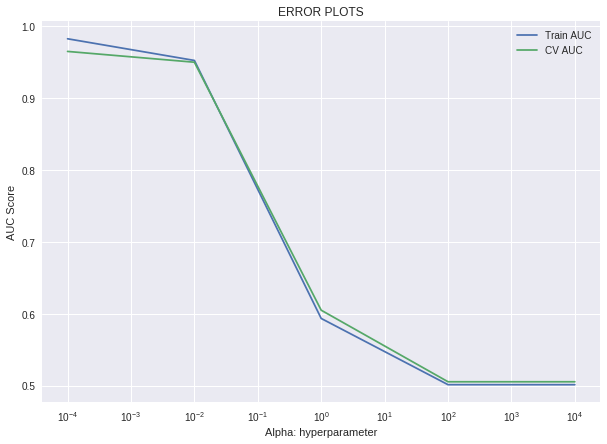

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,5)
for i in range(len(alpha)):
    sgd = SGDClassifier(loss="hinge",alpha=alpha[i])
    model = CalibratedClassifierCV(sgd,cv=10,method="isotonic")
    model.fit(X_train_vectors,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  model.predict_proba(X_calib_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

    
plt.figure(figsize=(10,7))    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC Score")
plt.title("ERROR PLOTS")
plt.xscale("log")
plt.show()

In [0]:
optimal_value_alpha_bow = 0.001 # As per my observation optimal value

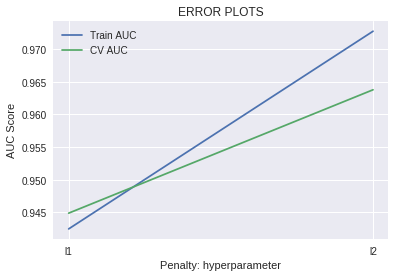

In [22]:
train_auc = []
cv_auc = []
penalty = ["l1","l2"]
for i in range(len(penalty)):
    sgd = SGDClassifier(loss="hinge",penalty=penalty[i],alpha=0.001)
    model = CalibratedClassifierCV(sgd,cv=10,method="isotonic")
    model.fit(X_train_vectors,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_vectors)[:,1]
    y_cv_pred =  model.predict_proba(X_calib_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.plot(penalty, train_auc, label='Train AUC')
plt.plot(penalty, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Penalty: hyperparameter")
plt.ylabel("AUC Score")
plt.title("ERROR PLOTS")
# plt.xscale("log")
plt.show()

In [0]:
# We will use "l2" Regularizer

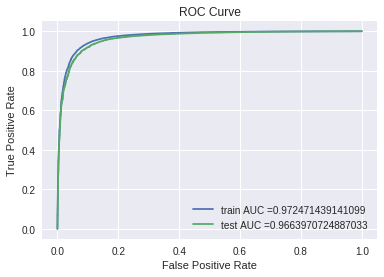

In [23]:
from sklearn.metrics import roc_curve, auc


model_optimal = SGDClassifier(alpha=optimal_value_alpha_bow,penalty="l2",loss="hinge")
model_1 = CalibratedClassifierCV(model_optimal,method="sigmoid")
model_1.fit(X_train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model_1.predict_proba(X_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_1.predict_proba(X_test_vectors)[:,1])

model_optimal_bow_train = auc(train_fpr, train_tpr)
model_optimal_bow_test = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# print("="*100)

# from sklearn.metrics import confusion_matrix
# print("Train confusion matrix")
# print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
# print("Test confusion matrix")
# print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

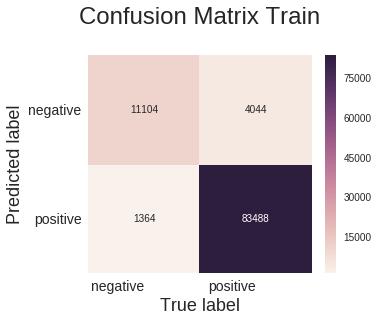

In [24]:
# For Train

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_bow = pd.DataFrame(confusion_matrix(y_train, model_1.predict(X_train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_bow = sns.heatmap(df_heatmap_bow, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_bow.yaxis.set_ticklabels(heatmap_bow.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_bow.xaxis.set_ticklabels(heatmap_bow.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

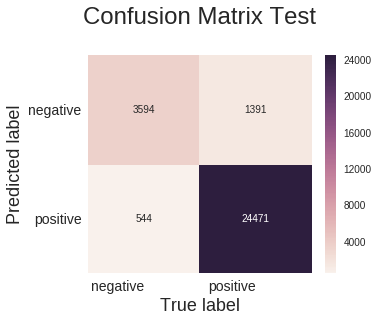

In [25]:
# For Test

# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_bow = pd.DataFrame(confusion_matrix(y_test, model_1.predict(X_test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_bow = sns.heatmap(df_heatmap_bow, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_bow.yaxis.set_ticklabels(heatmap_bow.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_bow.xaxis.set_ticklabels(heatmap_bow.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

In [26]:
# Find Top Features 

classifier = SGDClassifier(penalty='l2', alpha=optimal_value_alpha_bow ,loss='hinge')
classifier.fit(X_train_vectors, y_train)
top_pos_features = (-classifier.coef_[0, :]).argsort() #Note : Putting a - sign indicates the indexes will be sorted in descending order.
top_neg_features = (classifier.coef_[0, :]).argsort()  
top_pos_features = np.take(count_vect.get_feature_names(), top_pos_features[:10])
top_neg_features = np.take(count_vect.get_feature_names(), top_neg_features[:10])
    
print('The top 10 most important features from the positive class is: \n')
print(top_pos_features)
    
print('\nThe top 10 most important features from the negative class is: \n')
print(top_neg_features)

The top 10 most important features from the positive class is: 

['excellent' 'delicious' 'perfect' 'great' 'amazing' 'awesome' 'best'
 'loves' 'smooth' 'yummy']

The top 10 most important features from the negative class is: 

['disappointing' 'worst' 'terrible' 'disappointment' 'yuck' 'awful'
 'horrible' 'disappointed' 'rip' 'poor']


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# X_train_tfidf = tfidf_vect.fit_transform(X_train)
# X_test_tfidf = tfidf_vect.transform(X_test)
# X_calib_tfidf = tfidf_vect.transform(X_cv) 

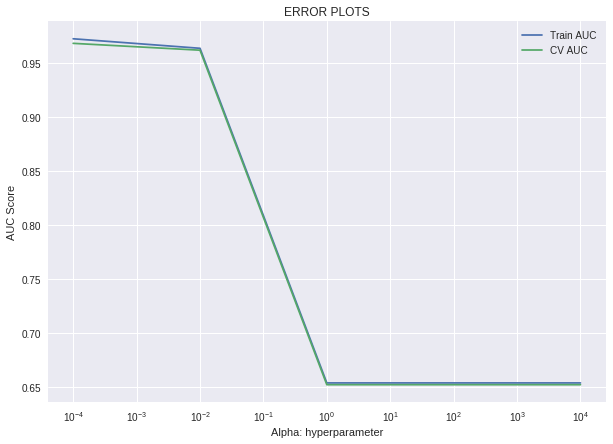

In [28]:
# Please write all the code with proper documentation
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,5)
for i in range(len(alpha)):
    sgd = SGDClassifier(loss="hinge",alpha=alpha[i])
    model = CalibratedClassifierCV(sgd,cv=10,method="sigmoid")
    model.fit(X_train_tfidf,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  model.predict_proba(X_calib_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.figure(figsize=(10,7))
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC Score")
plt.title("ERROR PLOTS")
plt.xscale("log")
plt.show()

In [0]:
optimal_value_tfidf_alpha = 0.001

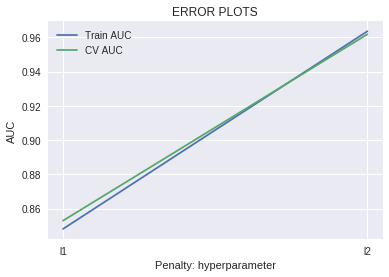

In [30]:
train_auc = []
cv_auc = []
penalty = ["l1","l2"]
for i in range(len(penalty)):
    sgd = SGDClassifier(loss="hinge",penalty=penalty[i],alpha=optimal_value_tfidf_alpha)
    model = CalibratedClassifierCV(sgd,cv=10,method="sigmoid")
    model.fit(X_train_tfidf,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  model.predict_proba(X_calib_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.plot(penalty, train_auc, label='Train AUC')
plt.plot(penalty, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Penalty: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
# plt.xscale("log")
plt.show()

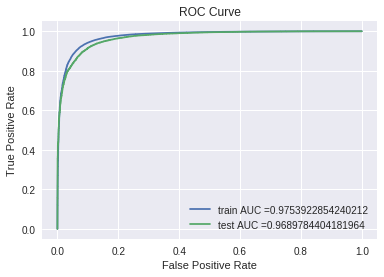

In [31]:
model_optimal = SGDClassifier(alpha=optimal_value_tfidf_alpha,penalty="l2",loss="hinge")
model_2 = CalibratedClassifierCV(model_optimal,method="isotonic")
model_2.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model_1.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_1.predict_proba(X_test_tfidf)[:,1])

model_optimal_tfidf_train = auc(train_fpr, train_tpr)
model_optimal_tfidf_test = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


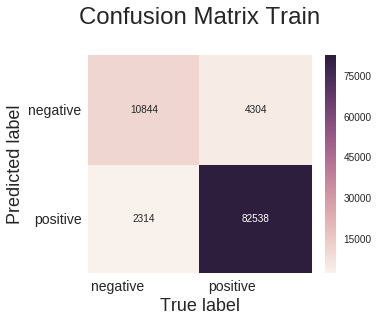

In [32]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_tfidf = pd.DataFrame(confusion_matrix(y_train, model_2.predict(X_train_tfidf)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_tfidf = sns.heatmap(df_heatmap_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidf.yaxis.set_ticklabels(heatmap_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidf.xaxis.set_ticklabels(heatmap_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

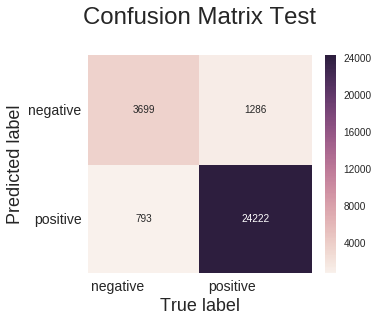

In [33]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_tfidf = pd.DataFrame(confusion_matrix(y_test, model_2.predict(X_test_tfidf)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_tfidf = sns.heatmap(df_heatmap_tfidf, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidf.yaxis.set_ticklabels(heatmap_tfidf.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidf.xaxis.set_ticklabels(heatmap_tfidf.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

In [34]:
# Finding top features

classifier_2 = SGDClassifier(penalty='l2', alpha=optimal_value_tfidf_alpha ,loss='hinge')
classifier_2.fit(X_train_tfidf, y_train)

top_pos_features = (-classifier_2.coef_[0, :]).argsort()#Note : Putting a - sign indicates the indexes will be sorted in descending order.
top_neg_features = (classifier_2.coef_[0, :]).argsort()  
top_pos_features = np.take(count_vect.get_feature_names(), top_pos_features[:10])
top_neg_features = np.take(count_vect.get_feature_names(), top_neg_features[:10])
    
print('The top 10 most important features from the positive class is: \n')
print(top_pos_features)
    
print('\nThe top 10 most important features from the negative class is: \n')
print(top_neg_features)

The top 10 most important features from the positive class is: 

['great' 'best' 'good' 'delicious' 'love' 'excellent' 'perfect' 'nice'
 'wonderful' 'loves']

The top 10 most important features from the negative class is: 

['awful' 'not' 'worst' 'horrible' 'terrible' 'disappointed' 'return'
 'stale' 'waste' 'money']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

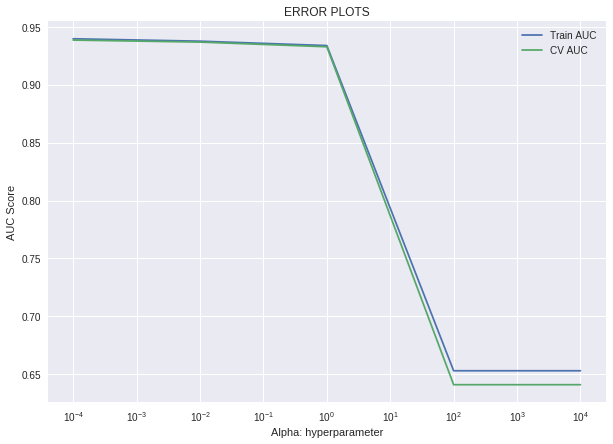

In [38]:
# Please write all the code with proper documentation
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,5)
for i in range(len(alpha)):
    sgd = SGDClassifier(loss="hinge",alpha=alpha[i])
    model = CalibratedClassifierCV(sgd,cv=10,method="sigmoid")
    model.fit(train_vectors,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(train_vectors)[:,1]
    y_cv_pred =  model.predict_proba(cv_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.figure(figsize=(10,7))    
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC Score")
plt.title("ERROR PLOTS")
plt.xscale("log")
plt.show()

In [0]:

optimal_value_avgw2vec = 0.1

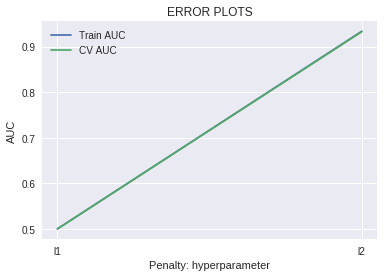

In [40]:
train_auc = []
cv_auc = []
penalty = ["l1","l2"]
for i in range(len(penalty)):
    sgd = SGDClassifier(loss="hinge",penalty=penalty[i],alpha=optimal_value_avgw2vec)
    model = CalibratedClassifierCV(sgd,cv=10,method="isotonic")
    model.fit(train_vectors,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(train_vectors)[:,1]
    y_cv_pred =  model.predict_proba(cv_vectors)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.plot(penalty, train_auc, label='Train AUC')
plt.plot(penalty, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Penalty: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
# plt.xscale("log")
plt.show()

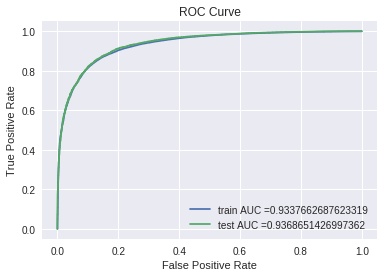

In [41]:
model_optimal = SGDClassifier(alpha=optimal_value_avgw2vec,penalty="l2",loss="hinge")
model_3 = CalibratedClassifierCV(model_optimal,method="sigmoid")
model_3.fit(train_vectors, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model_3.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_3.predict_proba(test_vectors)[:,1])

model_optimal_avgw2vec_train = auc(train_fpr, train_tpr)
model_optimal_avgw2vec_test = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

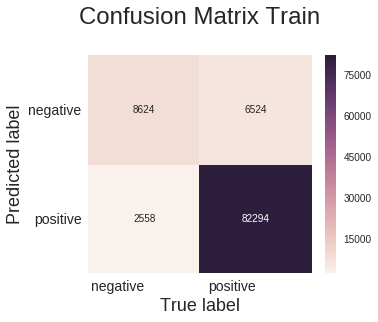

In [42]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_avgw2vec = pd.DataFrame(confusion_matrix(y_train, model_3.predict(train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_avgw2vec = sns.heatmap(df_heatmap_avgw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec.yaxis.set_ticklabels(heatmap_avgw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec.xaxis.set_ticklabels(heatmap_avgw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

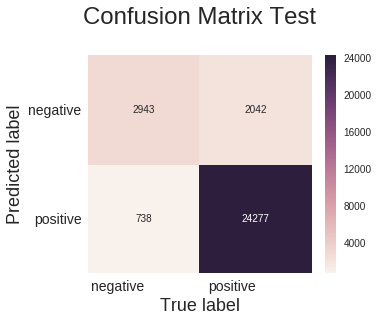

In [43]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_avgw2vec = pd.DataFrame(confusion_matrix(y_test, model_3.predict(test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_avgw2vec = sns.heatmap(df_heatmap_avgw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_avgw2vec.yaxis.set_ticklabels(heatmap_avgw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_avgw2vec.xaxis.set_ticklabels(heatmap_avgw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# X_train_tfidfw2vec = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
# X_test_tfidfw2vec = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
# tfidfw2vec = vectorize_tfidf_w2v(X_cv, tf_idf_object, word2vec_model, word2vec_words)


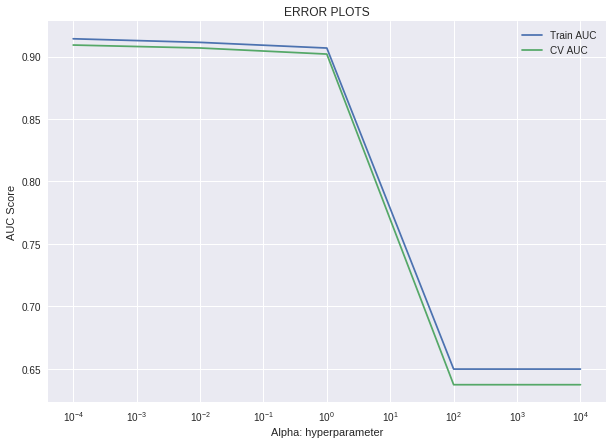

In [45]:
train_auc = []
cv_auc = []
alpha = np.logspace(-4,4,5)
for i in range(len(alpha)):
    sgd = SGDClassifier(loss="hinge",alpha=alpha[i])
    model = CalibratedClassifierCV(sgd,cv=10,method="sigmoid")
    model.fit(X_train_tfidfw2vec,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidfw2vec)[:,1]
    y_cv_pred =  model.predict_proba(X_calib_tfidfw2vec)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.figure(figsize=(10,7))   
plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC Score")
plt.title("ERROR PLOTS")
plt.xscale("log")
plt.show()

In [0]:

optimal_value_alpha_tfidf_w2vec = 0.001

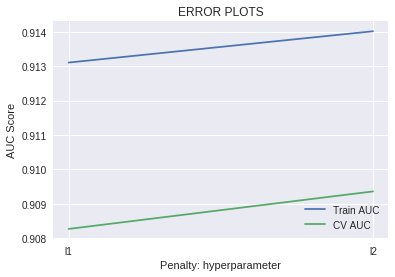

In [47]:
train_auc = []
cv_auc = []
penalty = ["l1","l2"]
for i in range(len(penalty)):
    sgd = SGDClassifier(loss="hinge",penalty=penalty[i],alpha=optimal_value_alpha_tfidf_w2vec)
    model = CalibratedClassifierCV(sgd,cv=10,method="isotonic")
    model.fit(X_train_tfidfw2vec,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_tfidfw2vec)[:,1]
    y_cv_pred =  model.predict_proba(X_calib_tfidfw2vec)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_calib, y_cv_pred))

plt.plot(penalty, train_auc, label='Train AUC')
plt.plot(penalty, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("Penalty: hyperparameter")
plt.ylabel("AUC Score")
plt.title("ERROR PLOTS")
# plt.xscale("log")
plt.show()

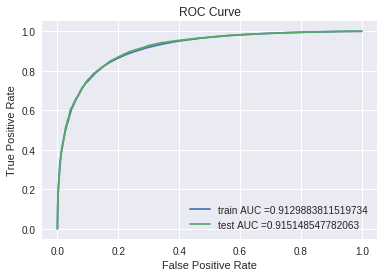

In [48]:
model_optimal = SGDClassifier(alpha=optimal_value_alpha_tfidf_w2vec,penalty="l2",loss="hinge")
model_4 = CalibratedClassifierCV(model_optimal,method="isotonic")
model_4.fit(X_train_tfidfw2vec, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model_4.predict_proba(X_train_tfidfw2vec)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_4.predict_proba(X_test_tfidfw2vec)[:,1])

model_optimal_tfidfw2vec_train = auc(train_fpr, train_tpr)
model_optimal_tfidfw2vec_test = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

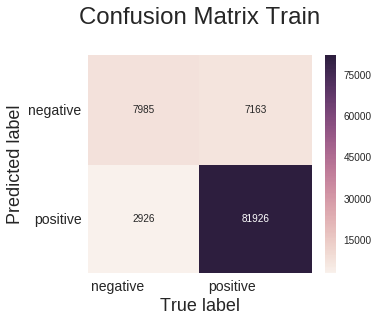

In [49]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_tfidfw2vec = pd.DataFrame(confusion_matrix(y_train, model_4.predict(X_train_tfidfw2vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_tfidfw2vec = sns.heatmap(df_heatmap_tfidfw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidfw2vec.yaxis.set_ticklabels(heatmap_tfidfw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidfw2vec.xaxis.set_ticklabels(heatmap_tfidfw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

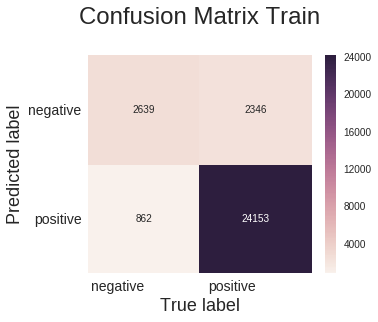

In [50]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_tfidfw2vec = pd.DataFrame(confusion_matrix(y_test, model_4.predict(X_test_tfidfw2vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_tfidfw2vec = sns.heatmap(df_heatmap_tfidfw2vec, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_tfidfw2vec.yaxis.set_ticklabels(heatmap_tfidfw2vec.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_tfidfw2vec.xaxis.set_ticklabels(heatmap_tfidfw2vec.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

## [5.2] RBF SVM

In [0]:
#Taking 20K balanced data points

my_final = final.take(np.random.permutation(len(final))[:20000])

In [57]:
my_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary,Final_Text
421930,456336,B000G7TBKM,A1JANFHYNNKRYN,"I-sung Yang ""chubby""",1,1,1,1286236800,Excellent taste for all ages,Bought a trial bag at a local market. Taste i...,bought trial bag local market taste addicting ...,excellent taste ages,bought trial bag local market taste addicting ...
485807,525318,B004DFULBG,A24WVAMG1CNFMB,"Yankee ""Carolina Yankee""",1,1,1,1328140800,Wish I could get this in bulk!,This is the second time I've purchased this ca...,second time purchased candy wish could purchas...,wish could get bulk,second time purchased candy wish could purchas...
136151,147770,B001D0IZBM,A2LKBULBM7LSHK,"Herman Meeks ""Hermesjax""",1,1,1,1287360000,K-Cups coffee,This is the best price for this coffee by subs...,best price coffee subscribing regular shipping...,k cups coffee,best price coffee subscribing regular shipping...
477910,516794,B002HFQWEO,A2FRFAQCWZJT3Q,"B. Davis ""The Happy Hermit""",1,1,1,1301875200,Have used this tea for many years,I'd been buying this same tea from Vitacost fo...,would buying tea vitacost years happy find ama...,used tea many years,would buying tea vitacost years happy find ama...
443854,479924,B002SCD4NI,A3BAYZRF4TYA6S,huffyone,0,0,1,1340150400,Best sauce out there,This is the only brand of pasta sauce I buy! I...,brand pasta sauce buy love no sugar natural in...,best sauce,brand pasta sauce buy love no sugar natural in...


In [0]:
X = my_final['Final_Text'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.preprocessing import normalize
count = CountVectorizer(min_df = 10,max_features=500)


In [0]:
# Please write all the code with proper documentation
X_train_vectors = count.fit_transform(X_train)
X_test_vectors = count.transform(X_test)

In [0]:
X_train_vectors = normalize(X_train_vectors,axis=0)
X_test_vectors = normalize(X_test_vectors,axis=0)

In [0]:
from sklearn.model_selection import GridSearchCV

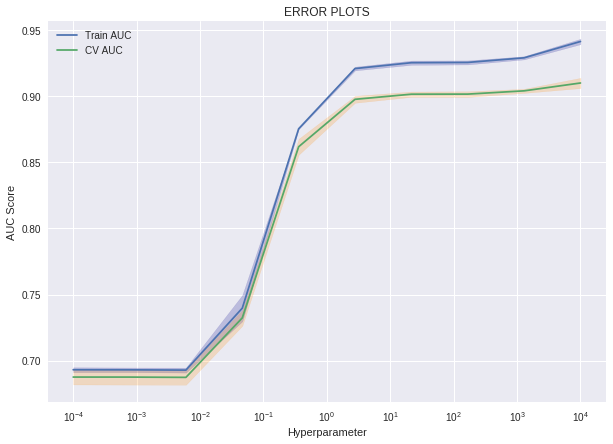

In [81]:
from sklearn.svm import SVC
svm = SVC()

Cs = np.logspace(-4,4,10)


parameters = {'C':Cs}
clf = RandomizedSearchCV(svm, parameters, cv=3, scoring='roc_auc')
clf.fit(X_train_vectors, y_train)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']


plt.figure(figsize=(10,7))
plt.plot(Cs, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(Cs, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC Score")
plt.xscale("log")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
clf.best_params_
optimal_value = 10000


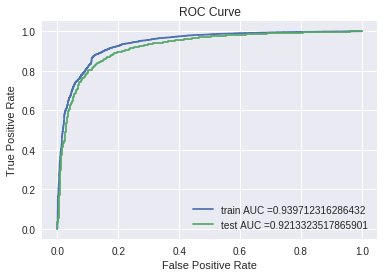

In [85]:
from sklearn.svm import SVC

model_rbf_1 = SVC(kernel='rbf',C=optimal_value)
model_rbf_1.fit(X_train_vectors, y_train)

score_roc_train = model_rbf_1.decision_function(X_train_vectors)
score_roc_test = model_rbf_1.decision_function(X_test_vectors)

train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

auc_1 = auc(test_fpr, test_tpr)


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

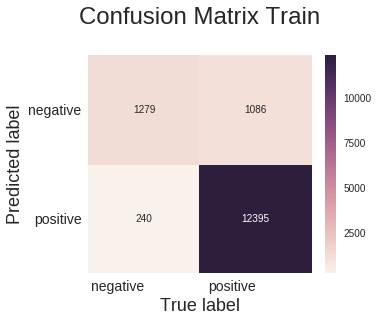

In [86]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf1 = pd.DataFrame(confusion_matrix(y_train, model_rbf_1.predict(X_train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf1 = sns.heatmap(df_heatmap_rbf1, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf1.yaxis.set_ticklabels(heatmap_rbf1.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf1.xaxis.set_ticklabels(heatmap_rbf1.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

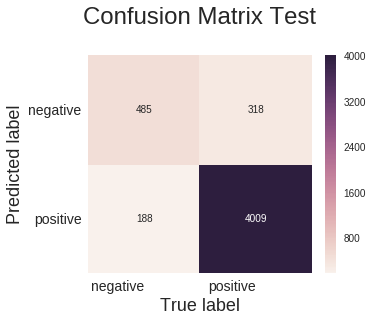

In [87]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf1 = pd.DataFrame(confusion_matrix(y_test, model_rbf_1.predict(X_test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf1 = sns.heatmap(df_heatmap_rbf1, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf1.yaxis.set_ticklabels(heatmap_rbf1.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf1.xaxis.set_ticklabels(heatmap_rbf1.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
tfidf = TfidfVectorizer(min_df = 10, max_features = 500)

X_train_vectors = tfidf.fit_transform(X_train)
X_test_vectors = tfidf.transform(X_test)

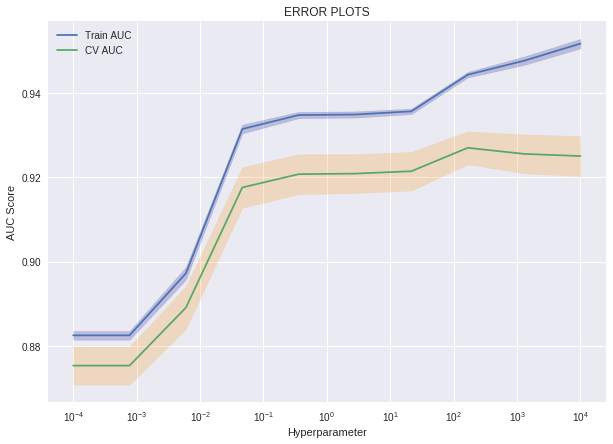

In [89]:
svm_2 = SVC(kernel='rbf')

Cs = np.logspace(-4,4,10)


parameters = {'C':Cs}
clf_2 = RandomizedSearchCV(svm_2, parameters, cv=5, scoring='roc_auc')
clf_2.fit(X_train_vectors, y_train)

train_auc= clf_2.cv_results_['mean_train_score']
train_auc_std= clf_2.cv_results_['std_train_score']
cv_auc = clf_2.cv_results_['mean_test_score'] 
cv_auc_std= clf_2.cv_results_['std_test_score']

plt.figure(figsize=(10,7))
plt.plot(Cs, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(Cs, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC Score")
plt.xscale("log")
plt.title("ERROR PLOTS")
plt.show()

In [92]:
print(clf_2.best_params_)

optimal_value_2 = 166.81005372000558



{'C': 166.81005372000558}


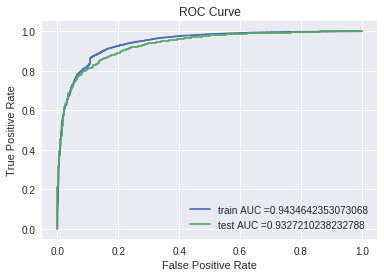

In [94]:
model_rbf_2 = SVC(kernel='rbf',C=optimal_value_2)
model_rbf_2.fit(X_train_vectors, y_train)

score_roc_train = model_rbf_2.decision_function(X_train_vectors)
score_roc_test = model_rbf_2.decision_function(X_test_vectors)

train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

auc_2 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

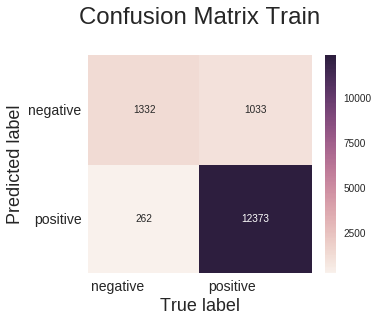

In [95]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf2 = pd.DataFrame(confusion_matrix(y_train, model_rbf_2.predict(X_train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf2 = sns.heatmap(df_heatmap_rbf2, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf2.yaxis.set_ticklabels(heatmap_rbf2.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf2.xaxis.set_ticklabels(heatmap_rbf2.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

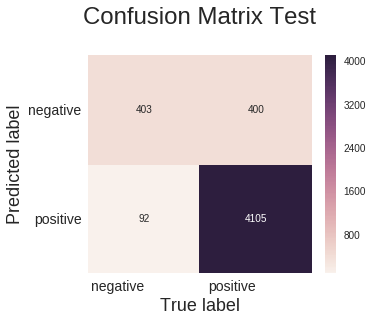

In [96]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf2 = pd.DataFrame(confusion_matrix(y_test, model_rbf_2.predict(X_test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf2 = sns.heatmap(df_heatmap_rbf2, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf2.yaxis.set_ticklabels(heatmap_rbf2.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf2.xaxis.set_ticklabels(heatmap_rbf2.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Test\n",size=24)
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [97]:
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   

# List of sentence in X_cv
sent_of_cv=[]
for sent in X_calib:
    sent_of_cv.append(sent.split())   

# # Train your own Word2Vec model using your own train text corpus 
# # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))


train_vectors = []
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
    
# # compute average word2vec for each review for X_cv    
# cv_vectors = []
# for sent in sent_of_cv:
#     sent_vec = np.zeros(50) 
#     cnt_words =0; 
#     for word in sent: # 
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     cv_vectors.append(sent_vec)

number of words that occured minimum 5 times  7876


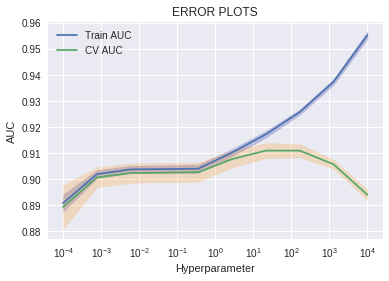

In [98]:
# Please write all the code with proper documentation
svm_3 = SVC(kernel='rbf')

Cs=np.logspace(-4,4,10)


parameters = {'C':Cs}
clf_3 = GridSearchCV(svm_3, parameters, cv=3, scoring='roc_auc')
clf_3.fit(train_vectors, y_train)

train_auc= clf_3.cv_results_['mean_train_score']
train_auc_std= clf_3.cv_results_['std_train_score']
cv_auc = clf_3.cv_results_['mean_test_score'] 
cv_auc_std= clf_3.cv_results_['std_test_score']

plt.plot(Cs, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(Cs, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.xscale("log")
plt.title("ERROR PLOTS")
plt.show()

In [100]:
optimal_value_3 = 21.5443
clf_3.best_params_

{'C': 21.54434690031882}

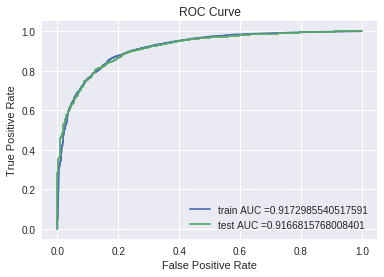

In [101]:
model_rbf_3 = SVC(kernel='rbf',C=optimal_value_3)
model_rbf_3.fit(train_vectors, y_train)

score_roc_train = model_rbf_3.decision_function(train_vectors)
score_roc_test = model_rbf_3.decision_function(test_vectors)

train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

auc_3 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

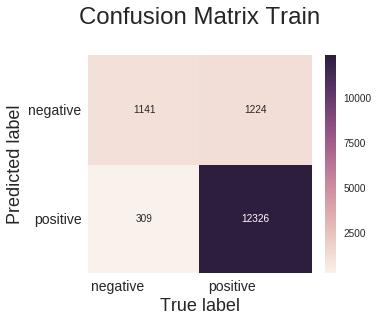

In [102]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf3 = pd.DataFrame(confusion_matrix(y_train, model_rbf_3.predict(train_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf3 = sns.heatmap(df_heatmap_rbf3, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf3.yaxis.set_ticklabels(heatmap_rbf3.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf3.xaxis.set_ticklabels(heatmap_rbf3.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

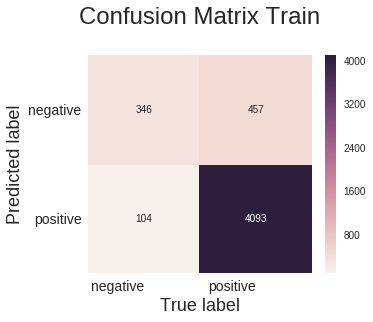

In [103]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf3 = pd.DataFrame(confusion_matrix(y_test, model_rbf_3.predict(test_vectors)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf3 = sns.heatmap(df_heatmap_rbf3, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf3.yaxis.set_ticklabels(heatmap_rbf3.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf3.xaxis.set_ticklabels(heatmap_rbf3.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [104]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(50) #50 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_tfidfw2vec = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_tfidfw2vec = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
# X_calib_tfidfw2vec = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
# print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

100%|██████████| 5000/5000 [01:38<00:00, 50.82it/s]

The shape of our TF-IDF Avg Word2Vec train vectorizer  (15000, 500)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (5000, 500)


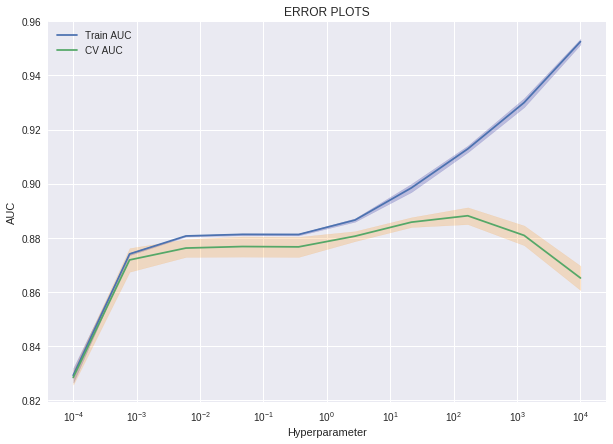

In [105]:
# Please write all the code with proper documentation
#X_train_tfidfw2vec

svm_4 = SVC(kernel='rbf')

Cs=np.logspace(-4,4,10)


parameters = {'C':Cs}
clf_4 = RandomizedSearchCV(svm_3, parameters, cv=3, scoring='roc_auc')
clf_4.fit(X_train_tfidfw2vec, y_train)

train_auc= clf_4.cv_results_['mean_train_score']
train_auc_std= clf_4.cv_results_['std_train_score']
cv_auc = clf_4.cv_results_['mean_test_score'] 
cv_auc_std= clf_4.cv_results_['std_test_score']

plt.figure(figsize=(10,7))
plt.plot(Cs, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(Cs, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(Cs,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.xscale("log")
plt.title("ERROR PLOTS")
plt.show()

In [107]:
optimal_value_4 = 166.810
clf_4.best_params_

{'C': 166.81005372000558}

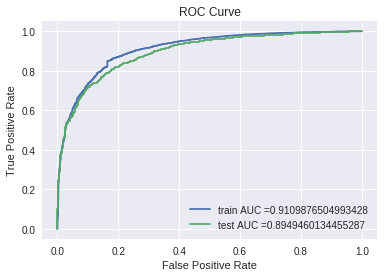

In [109]:
model_rbf_4 = SVC(kernel='rbf',C=optimal_value_4)
model_rbf_4.fit(X_train_tfidfw2vec, y_train)

score_roc_train = model_rbf_4.decision_function(X_train_tfidfw2vec)
score_roc_test = model_rbf_4.decision_function(X_test_tfidfw2vec)

train_fpr, train_tpr, thresholds = roc_curve(y_train, score_roc_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, score_roc_test)

auc_4 = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

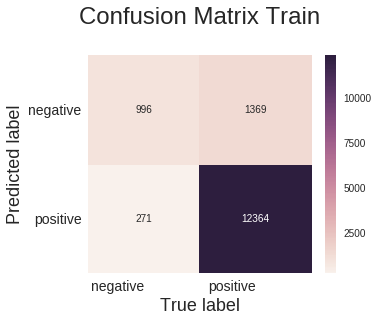

In [110]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf4 = pd.DataFrame(confusion_matrix(y_train, model_rbf_4.predict(X_train_tfidfw2vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf4 = sns.heatmap(df_heatmap_rbf4, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf4.yaxis.set_ticklabels(heatmap_rbf4.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf4.xaxis.set_ticklabels(heatmap_rbf4.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

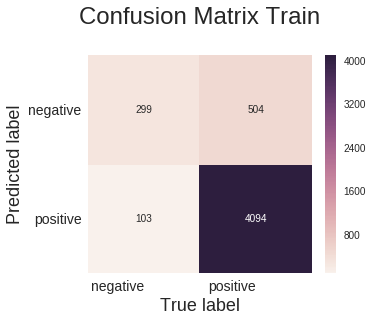

In [111]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap_rbf4 = pd.DataFrame(confusion_matrix(y_test, model_rbf_4.predict(X_test_tfidfw2vec)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,4))
heatmap_rbf4 = sns.heatmap(df_heatmap_rbf4, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap_rbf4.yaxis.set_ticklabels(heatmap_rbf4.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap_rbf4.xaxis.set_ticklabels(heatmap_rbf4.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix Train\n",size=24)
plt.show()

# [6] Conclusions

In [112]:
# Please compare all your models using Prettytable library
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['SGD for BoW','SGD for TFIDF',\
         'SGD for Avg_Word2Vec',\
         'SGD for tfidf_Word2Vec',\
         "SVC(RBF Kernel) for BOW","SVC(RBF Kernel) for TFIDF","SVC(RBF Kernel) for Avg_Word2Vec","SVC(RBF Kernel) for tfidf_Word2Vec"]


optimal_regularization = ["l2", "l2", "l2", "l2", 
                          "NA","NA","NA","NA"]

# Training accuracies
optimal_alpha = [optimal_value_alpha_bow, optimal_value_tfidf_alpha, optimal_value_avgw2vec, optimal_value_alpha_tfidf_w2vec,
                 "NA","NA","NA","NA"]

# Test accuracies
train_acc = [model_optimal_bow_train,model_optimal_tfidf_train,model_optimal_avgw2vec_train,model_optimal_tfidfw2vec_train,
            0.9397,0.9434,0.9172,0.91098]


test_acc = [model_optimal_bow_test,model_optimal_tfidf_test,model_optimal_avgw2vec_test, model_optimal_tfidfw2vec_test,
            auc_1,auc_2,auc_3,auc_4]

optimal_C = ["NA","NA","NA","NA",
            optimal_value,optimal_value_2,optimal_value_3,optimal_value_4]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Best Regularization",optimal_regularization)
ptable.add_column("Best C",optimal_C)
ptable.add_column("Training AUC",train_acc)
ptable.add_column("Test AUC",test_acc)

# Printing the Table
print(ptable)

+-------+------------------------------------+------------+---------------------+--------------------+--------------------+--------------------+
| S.NO. |               MODEL                | Best Alpha | Best Regularization |       Best C       |    Training AUC    |      Test AUC      |
+-------+------------------------------------+------------+---------------------+--------------------+--------------------+--------------------+
|   1   |            SGD for BoW             |   0.001    |          l2         |         NA         | 0.972471439141099  | 0.9663970724887033 |
|   2   |           SGD for TFIDF            |   0.001    |          l2         |         NA         | 0.9753922854240212 | 0.9689784404181964 |
|   3   |        SGD for Avg_Word2Vec        |    0.1     |          l2         |         NA         | 0.9337662687623319 | 0.9368651426997362 |
|   4   |       SGD for tfidf_Word2Vec       |   0.001    |          l2         |         NA         | 0.9129883811519734 | 0.9151